# BATs Language Metrics
This is an attempt to jupyterize Wally's Language Metrics script (lang_metrics.py)

Comment from the original script:
   PURPOSE: Calculate various metrics to describe code-switching behavior in language-tagged corpora.


In [1]:
# Lets import modules needed
import sys
import math
import numpy as np
import pandas as pd
from itertools import groupby
from collections import Counter
import csv
%matplotlib inline

In [2]:
# These were the crux of the script. I would have preferred to rewrite these scripts 
# so they take some subset of the inputs: LANGS, LANG_TAGS and NUMTAGS
# but for now I am leaving them as they are. 
# Future plan: Make a class with these variables as class members and define a constructor
#              that does input file parsing and initializes these variables
def metrics():
        print("Number of switchpoints: {}".format(num_switchpoints()))
        print("M-metric: {}".format(m_metric()))
        print("I-metric: {}".format(i_metric()))
        print("Normalized I-metric: {}".format(norm_i_metric()))
        print("Coefficient of Variation: {}".format(coeff()))
        print("Burstiness: {}".format(burstiness()))
        print("Normalized Burstiness: {}".format(norm_burstiness()))
        print("Fano: {}".format(fano_factor()))
        print("Memory: {}".format(memory()))
        print("Language Entropy: {}".format(lang_entropy()))
        print("Span Entropy: {}".format(span_entropy()))
        print("Switch Entropy: {}".format(switch_entropy()))
        print("Switch Surprisal: {}".format(switch_surprisal()))


def num_switchpoints():
        num_switches = 0

        for index, tag in enumerate(LANG_TAGS[1:]):
                if tag != LANG_TAGS[index - 1]:
                        num_switches += 1

        return num_switches


def m_metric():
        num_langs = len(LANGS)
        counts = Counter(LANG_TAGS)
        m_metric = 0.0

        if num_langs == 1:
                return 0

        # Compute p_i^2 for all languages in text
        p_lang = {}
        for lang, count in counts.items():
                p_lang[lang] = (count / float(NUMTAGS)) ** 2

        p_sum = sum(p_lang.values())
        m_metric = (1 - p_sum) / ((num_langs - 1) * p_sum)

        return m_metric


def i_metric():
        # Count number of language switches for each language
        switches = {lang: {} for lang in LANGS}
        counts = Counter(zip(LANG_TAGS, LANG_TAGS[1:]))

        # Compute transition probabilities
        for (x, y), c in counts.items():
                switches[x][y] = c / float(NUMTAGS - 1)

        i_metric = 0.0

        # Sum all probabilities of switching language
        for lang1, switch in switches.items():
                for lang2, prob in switch.items():
                        if lang1 != lang2:
                                i_metric += prob

        return i_metric
        
def norm_i_metric():
        i = i_metric()
        counts = Counter(LANG_TAGS)
        num_langs = len(LANGS)
        
        low = (num_langs - 1) / (NUMTAGS - 1)
        least = NUMTAGS - max(counts.values())
        high = min(2*least / (NUMTAGS - 1), 1)
        
        norm_i = (i - low)/(high - low)
        
        return norm_i
    
def coeff():
        # Coefficient of Variation: standard deviation over mean, range [0, Infinity) or more accurately [0, max_coeff]
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        mean = np.mean(spans)
        sd = np.std(spans)
        coeff = sd/mean

        return coeff    

def burstiness():
        # maps coeff. of variation onto range [-1, 1) or more accurately [-1, max_burstiness]
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        mean = np.mean(spans)
        sd = np.std(spans) # B = -1 with std. dev. = 0, B = 1 when std. dev. -> Infinity
        burstiness = (sd - mean)/(sd + mean) # B = 0 when std. dev. = mean

        return burstiness
    
def norm_burstiness():
        # maps coeff. of variation onto range [-1, 1] with normalized burstiness = 1 when the coeff. of variation is maximized
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        mean = np.mean(spans)
        sd = np.std(spans)
        I = i_metric()
        burstiness = (sd - mean)/(sd + mean)
        max_coeff = ((mean - 1)*math.sqrt(I*(NUMTAGS - 1)))/mean
        Bmax = (max_coeff - 1)/(max_coeff + 1)
        norm_burstiness = 2*(burstiness + 1)/(Bmax + 1) - 1
        
        return norm_burstiness

def fano_factor():
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        mean = np.mean(spans)
        var = np.var(spans)
        fano = var / mean

        return fano

def memory():
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        mean1 = np.mean(spans[:-1])
        mean2 = np.mean(spans[1:])
        sd1 = np.std(spans[:-1])
        sd2 = np.std(spans[1:])
        memory = 0.0

        for i, span in enumerate(spans[:-1]):
                memory += (span - mean1) * (spans[i + 1] - mean2)

        memory /= (len(spans) - 1) * (sd1 * sd2)

        return memory


def spans():
        spans = [(lang, len(list(group))) for lang, group in groupby(LANG_TAGS)]

        print("Lang\tLength")

        for lang, length in spans:
                print("{}\t{}".format(lang, length))


def span_summary():
        spans = sorted([(lang, len(list(group))) for lang, group in groupby(LANG_TAGS)])
        spans = sorted([(c, len(list(cgen))) for c, cgen in groupby(spans)])

        print("Lang\tSpanLength\tSpanFreq")

        for (lang, length), freq in spans:
                print("{}\t{}\t{}".format(lang, length, freq))


def switchpoints():
        switchpoints = []

        # Compute vector of switch indices
        for index, tag in enumerate(LANG_TAGS[:-1]):
                if tag != LANG_TAGS[index + 1]:
                        switchpoints.append(index + 1)
                else:
                        switchpoints.append(0)

        for switch in switchpoints:
                print("{}".format(switch))


def lang_entropy():
        # Count frequencies of language tokens
        counts = Counter(LANG_TAGS)
        num_langs = len(LANGS)


        # Compute entropy based on unigram language tokens
        lang_entropy = 0.0
        for lang, count in counts.items():
                lang_prob = count / float(NUMTAGS)
                lang_entropy -= lang_prob * math.log2(lang_prob)
                
        lang_entropy /= math.log2(num_langs)

        return lang_entropy


def span_entropy():
        # Get frequencies of language spans
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        span_counts = Counter(spans)
        total_count = len(spans)

        # Compute entropy based on spans of language tokens
        span_entropy = 0.0
        for length, count in span_counts.items():
                span_prob = count / float(total_count)
                span_entropy -= span_prob * math.log2(span_prob)
                
        span_entropy /= math.log2(len(span_counts))

        return span_entropy


def switch_entropy():
        switch_entropy = 0

        # Compute vector of switch indices
        for index, tag in enumerate(LANG_TAGS[:-1]):
                if tag != LANG_TAGS[index + 1]:
                        switch_entropy += 1
        
        switch_entropy = switch_entropy / (NUMTAGS - 1)
        switch_entropy = - switch_entropy * math.log2(switch_entropy)

        return switch_entropy


def switch_surprisal():
        surprisal = 0

        # Compute vector of switch indices
        for index, tag in enumerate(LANG_TAGS[:-1]):
                if tag != LANG_TAGS[index + 1]:
                        surprisal += 1

        surprisal = surprisal / (NUMTAGS - 1)
        surprisal = -math.log2(surprisal)

        return surprisal

## Process
### Step1: Import file using pandas' `read_csv`
#### Delimiter
The input file is expected to be a comma(or tab) separated file specified by the delimiter.
#### Header
If the file has NO header then let read_csv know it, because by default it expects a header.

### Step2: Read all columns and give names to columns of interest
The file may have multiple columns but we only need the word and its language tag. If it has other columns just read them and ignore them. For example, the Solorio_7k dataset that has 3 columns and the KC dataset which has 7 columns. 
### Step3: Preprocessing data
#### Non-word tokens
Look for only tokens that have word characters;  Word characters include letters (lowercase,uppercase), digits, underscore and hyphen (`A-Za-z0-9_-`). It also includes unicode characters from other languages (needs testing to make sure).
#### Puntuation and Named Entities
For now, we will treat them the same way. Replace the language TAG ('Punct'/'Other', 'NamedEnt') with the language TAG preceeding it. 

In [3]:
langdata = pd.read_csv('../Solorio7k/SolorioGoldStandard',header=None,sep='\t')
langdata.columns = ['word', 'language']
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('\w+', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets use then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
# LANG_TAGS without puntuation and Named Entinty
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 514
M-metric: 0.6032507267542166
I-metric: 0.08076814459192319
Normalized I-metric: 0.16020236087689715
Coefficient of Variation: 1.7815338411957324
Normalized Coefficient of Variation: 0.11463272695732897
Deviation Surprisal: 3.1249091111887246
Burstiness: 0.2809722569687539
Normalized Burstiness: 0.3633963679103993
Fano: 39.170111966506454
Memory: -0.12955480386964177
Language Entropy: 0.8132855669302232
Span Entropy: 0.8026734232749696
Switch Entropy: 0.29319400180773303
Switch Surprisal: 3.6300697916125264


In [4]:
#Lets try it on a different dataset - KillerCronicas
langdata = pd.read_csv('../KillerCronicas/Killer_Cronicas-output.txt',
                       delimiter=",",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language']
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('\w+', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 12757
M-metric: 0.9900635012562844
I-metric: 0.22435544430538173
Normalized I-metric: 0.24138766935114608
Coefficient of Variation: 1.076012591485091
Normalized Coefficient of Variation: 0.014653412574766144
Deviation Surprisal: 6.092619502508575
Burstiness: 0.03661470638321851
Normalized Burstiness: 0.05073158855904736
Fano: 5.160128461582305
Memory: -0.013759199094242879
Language Entropy: 0.9963952680740547
Span Entropy: 0.6132748078068649
Switch Entropy: 0.4837421742722639
Switch Surprisal: 2.1561419013920498


In [5]:
#Lets try it on a different dataset - Solorio7k
langdata = pd.read_csv('../Solorio7k/Solorio_7k-output.txt',
                       delimiter=",",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language','yn']
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('\w+', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 1308
M-metric: 0.36602988074363463
I-metric: 0.16013681592039805
Normalized I-metric: 0.2675689744924519
Coefficient of Variation: 1.5097400660160218
Normalized Coefficient of Variation: 0.05601992716812477
Deviation Surprisal: 4.157916082018384
Burstiness: 0.2031047250344083
Normalized Burstiness: 0.24774674029860355
Fano: 14.221953274090026
Memory: -0.17457413757262538
Language Entropy: 0.582598923970836
Span Entropy: 0.6408204873222269
Switch Entropy: 0.4231812439648008
Switch Surprisal: 2.642623069108348


In [6]:
#Lets try it on a different dataset - KillerCronicas
langdata = pd.read_csv('KC_Output_Annotated_Complete.txt',
                       delimiter="\t",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language','ne','e_ng_prob','sp_ng_prob','hmm_prob', 'tot_prob' ]
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('\w+', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 13337
M-metric: 0.9885346558017482
I-metric: 0.23391929187697358
Normalized I-metric: 0.2531144894389883
Coefficient of Variation: 1.030729445449497
Normalized Coefficient of Variation: 0.013871783462476214
Deviation Surprisal: 6.171702906290486
Burstiness: 0.015132220354787444
Normalized Burstiness: 0.02879409293319557
Fano: 4.54138126160089
Memory: -0.025836625300681752
Language Entropy: 0.9958369025453956
Span Entropy: 0.6170865451969784
Switch Entropy: 0.49027547797492654
Switch Surprisal: 2.0959172458198947


In [7]:
#Lets try it on a different dataset - YYB
langdata = pd.read_csv('YYB_Output_Annotated.txt',
                       delimiter="\t",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language','ne','e_ng_prob','sp_ng_prob','hmm_prob', 'tot_prob' ]
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('\w+', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 3202
M-metric: 0.9674659760199197
I-metric: 0.036769555467616406
Normalized I-metric: 0.042176767772332494
Coefficient of Variation: 2.1998448038857603
Normalized Coefficient of Variation: 0.048363371819375535
Deviation Surprisal: 4.369941359217569
Burstiness: 0.3749696867887837
Normalized Burstiness: 0.4051982602249986
Fano: 131.5552427201249
Memory: -0.11611865333926795
Language Entropy: 0.9880387014531635
Span Entropy: 0.6707329512030981
Switch Entropy: 0.17521959725520922
Switch Surprisal: 4.765344454858265


In [8]:
#Lets try it on a different dataset - BCBC
langdata = pd.read_csv('../BonCop/BonCopTokensByLine_annotatedWithHMM_v4.tsv',
                       delimiter="\t",quoting=csv.QUOTE_NONE, comment='#', encoding='utf-8')
# Rename columns
langdata.columns = ['word', 'language']
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 1058
M-metric: 0.9467069340327517
I-metric: 0.044737426857269835
Normalized I-metric: 0.05351912665305761
Coefficient of Variation: 1.6479784684240049
Normalized Coefficient of Variation: 0.07020086567984017
Deviation Surprisal: 3.8323673685851745
Burstiness: 0.24470684945171087
Normalized Burstiness: 0.2977290824622547
Fano: 60.61021091457525
Memory: -0.12960969783108436
Language Entropy: 0.9801612808125195
Span Entropy: 0.8099598519045739
Switch Entropy: 0.20052987493849045
Switch Surprisal: 4.482373909841986


In [9]:
#Lets try it on a different dataset - KillerCronicas Gold Standard
langdata = pd.read_csv('../KillerCronicas/KillerCronicasGoldStandard',
                       delimiter="\t",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language']
# The Gold Standard has way more language tags than the others:
# array(['Spn', 'Eng', Punct', 'NamedEnt', Num', 'EngNoSpace', 'NonStSpn', 'Ital',
#       'MixedNoSpace', 'Afrk', 'NonStEng', 'Mixed', 'Frn', 'SpnNoSpace',
#       'EngNonSt', 'Yidd', 'Latin']
#We still are only interested in languages tagged as Eng or Spn
# Tokens tagged with language values that seem like Eng/Spn and Punct, NamedEnt
# will be kept and now converted to NaN. 
# This lets us then do a fillna with a ffill method to 
# replace them with the previous language (hopefully Eng or Spn)
langdata.replace(['Punct', 'NamedEnt'
                ,'Num' , 'EngNoSpace', 'NonStSpn','MixedNoSpace', 'NonStEng', 'SpnNoSpace','EngNonSt'
                 ]
                  ,[None, None
                 , None , None, None, None, None, None, None
                   ], inplace=True)
langdata.fillna(method='ffill', inplace=True)
# Now drop other languages that are not Eng, Spn 
langdata = langdata[langdata['language'].str.contains('^Spn$|^Eng$', regex=True)]
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 2530
M-metric: 0.9879129203422643
I-metric: 0.14078777656513541
Normalized I-metric: 0.15258796943936292
Coefficient of Variation: 0.9207976132245511
Normalized Coefficient of Variation: 0.028452185221834975
Deviation Surprisal: 5.135316729241599
Burstiness: -0.0412341134902221
Normalized Burstiness: -0.011608727633905191
Fano: 6.01867035546613
Memory: 0.04419927216271496
Language Entropy: 0.9956095450334453
Span Entropy: 0.7868557189463902
Switch Entropy: 0.3982049937541405
Switch Surprisal: 2.828406012718803


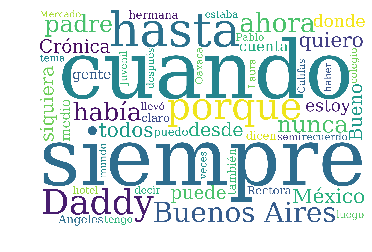

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
# Get all words 
#all_words = ' '.join(langdata['word'])
# Get only English words
eng_words = langdata[langdata['language'].str.contains(r'^Eng$')]['word']
# Get only Spanish words
spn_words = langdata[langdata['language'].str.contains(r'^Spn$')]['word']
# Get only words that are longer than N chars
N = 4
eng_string = ' '.join(x for x in eng_words if len(x)>N)
spn_string = ' '.join(x for x in spn_words if len(x)>N)
Ewordcloud = WordCloud(font_path=plt.__file__+'\\..\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf',max_words=50,background_color='white',
                          width=2400,
                          height=1600).generate(eng_string)
Swordcloud = WordCloud(font_path=plt.__file__+'\\..\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf',max_words=50,background_color='white',
                          width=2400,
                          height=1600).generate(spn_string)
plt.imshow(Swordcloud)
plt.axis('off')
plt.show()

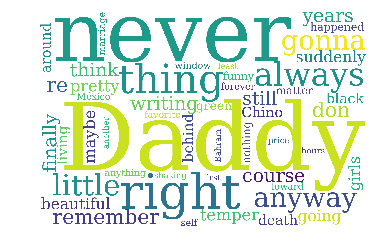

In [11]:
plt.imshow(Ewordcloud)
plt.axis('off')
plt.show()